In [1]:
from cnn import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from keras import backend as K
from keras.optimizers import Adam

from PIL import Image
import numpy as np

Using TensorFlow backend.


### Read images and shuffle

In [2]:
data_dir_oil_wet = './data/SS2_data_200by200/200by200_SS2_OilWet/'
data_dir_water_wet = './data/SS2_data_200by200/200by200_SS2_WaterWet/'

In [3]:
num_images, dim_x = 1600, 200

In [4]:
data_water_wet = np.zeros((num_images, dim_x, dim_x, 3))
data_oil_wet = np.zeros((num_images, dim_x, dim_x, 3))

In [10]:
import glob
ct = 0
for fn in glob.glob(data_dir_water_wet +'*.tif'):
    data_water_wet[ct, ...] = np.array(Image.open(fn))
    ct += 1
    if ct%100 == 0:
        print(ct)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


In [11]:
ct = 0
for fn in glob.glob(data_dir_oil_wet +'*.tif'):
    data_oil_wet[ct, ...] = np.array(Image.open(fn))
    ct += 1
    if ct%100 == 0:
        print(ct)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


In [12]:
data_water_wet.shape

(1600, 200, 200, 3)

In [13]:
label_water_wet = np.zeros((num_images,2))
label_water_wet[:, 0] = 1.
label_oil_wet = np.zeros((num_images,2))
label_oil_wet[:, 1] = 1.

In [14]:
all_data_raw = np.append(data_water_wet, data_oil_wet, axis=0)
all_label_raw = np.append(label_water_wet, label_oil_wet, axis=0)

In [15]:
# np.random.seed(1)
randomize = np.array (np.arange(all_data_raw.shape[0]))
np.random.shuffle(randomize)
all_data = all_data_raw[randomize] / 255.
all_label = all_label_raw[randomize]

In [16]:
num_train, num_eval, num_test = 3000, 100, 100

In [17]:
train_data = all_data[:num_train, ...]
train_label = all_label[:num_train, :]

In [18]:
eval_data = all_data[num_train:(num_train+num_eval), ...]
eval_label = all_label[num_train:(num_train+num_eval):, :]

In [19]:
test_data = all_data[-num_test:, ...]
test_label = all_label[-num_test:, :]

In [20]:
print(train_data.shape)
print(eval_data.shape)
print(test_data.shape)

(3000, 200, 200, 3)
(100, 200, 200, 3)
(100, 200, 200, 3)


In [21]:
print(train_label.shape)
print(eval_label.shape)
print(test_label.shape)

(3000, 2)
(100, 2)
(100, 2)


## Save data

In [23]:
import h5py

In [24]:
fn = h5py.File('./saved_models/rock_image_ss2_200x200_onehotlabels.h5', 'w')
fn.create_dataset('train', data=train_data)
fn.create_dataset('train_label', data=test_label)
fn.create_dataset('eval', data=eval_data)
fn.create_dataset('eval_label', data=eval_label)
fn.create_dataset('test', data=test_data)
fn.create_dataset('test_label', data=test_label)
fn.close()

### Plot images

In [25]:
import matplotlib.pyplot as plt

In [26]:
title_dict = {0.0: 'oil wet', 1.0: 'water wet'}

/data/cees/wyun/miniconda3/envs/keras-gpu/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


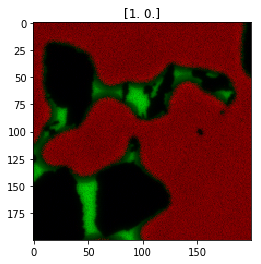

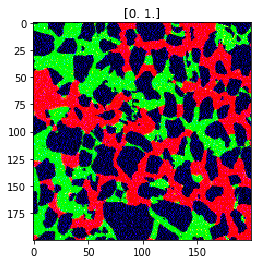

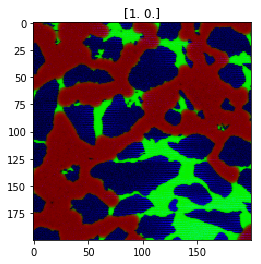

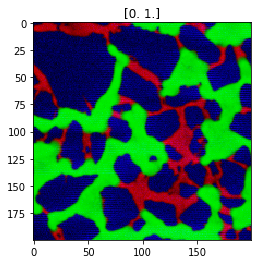

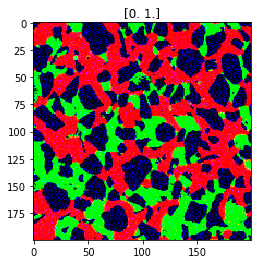

In [27]:
for k in range(5):
    plt.imshow(train_data[k, ...])
    plt.title(train_label[k])
    plt.show()

## Construct CNN

In [28]:
input_shape =(dim_x, dim_x, 3)
hidden_dim = 500
output_dim = 2

In [29]:
cnn_model = create_cnn(input_shape, hidden_dim, output_dim)

In [30]:
cnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 3)       84        
_________________________________________________________________
activation_1 (Activation)    (None, 200, 200, 3)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 3)       84        
_________________________________________________________________
activation_2 (Activation)    (None, 100, 100, 3)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 3)         0         
__________

## Train the model

In [31]:
hist = cnn_model.fit(x=train_data, y=train_label, batch_size=50, epochs=50, validation_data=(eval_data, eval_label), verbose=True)

Train on 3000 samples, validate on 100 samples
Epoch 1/50
3000/3000 [==============================] - 25s 8ms/step - loss: 0.7374 - acc: 0.5843 - val_loss: 0.5887 - val_acc: 0.5400
Epoch 2/50
3000/3000 [==============================] - 3s 869us/step - loss: 0.5280 - acc: 0.6847 - val_loss: 0.5147 - val_acc: 0.6700
Epoch 3/50
3000/3000 [==============================] - 3s 879us/step - loss: 0.4304 - acc: 0.7890 - val_loss: 0.4112 - val_acc: 0.8100
Epoch 4/50
3000/3000 [==============================] - 3s 857us/step - loss: 0.2980 - acc: 0.8880 - val_loss: 0.2903 - val_acc: 0.8600
Epoch 5/50
3000/3000 [==============================] - 3s 856us/step - loss: 0.2317 - acc: 0.9080 - val_loss: 0.4061 - val_acc: 0.8000
Epoch 6/50
3000/3000 [==============================] - 3s 842us/step - loss: 0.1755 - acc: 0.9307 - val_loss: 0.1212 - val_acc: 0.9600
Epoch 7/50
3000/3000 [==============================] - 3s 844us/step - loss: 0.1157 - acc: 0.9580 - val_loss: 0.0900 - val_acc: 0.9600
Ep

## Save trained model

In [32]:
cnn_model.save_weights('./saved_models/cnn_ss2_200x200_onehotlabel.h5')

## Plot the training process

In [33]:
hist.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

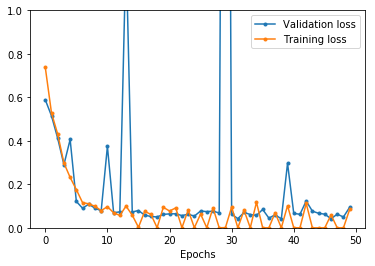

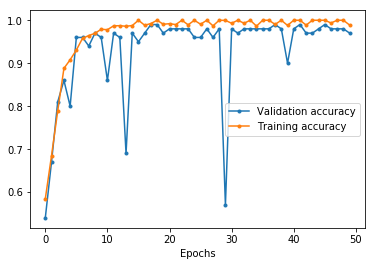

In [35]:
plt.plot(hist.history['val_loss'], marker='.')
plt.plot(hist.history['loss'], marker='.')
plt.legend(['Validation loss', 'Training loss'])
plt.xlabel('Epochs')
plt.ylim([0,1])
plt.figure()
plt.plot(hist.history['val_acc'], marker='.')
plt.plot(hist.history['acc'], marker='.')
plt.xlabel('Epochs')
plt.legend(['Validation accuracy', 'Training accuracy'])
plt.show()

In [37]:
import pickle

In [38]:
pickle.dump( hist.history, open( "saved_models/hist_conv_ss2_200x200_onehot_label.pickle", "wb" ) )

## Plot the saliency map

In [111]:
from keras.losses import binary_crossentropy
import keras.backend as K

def normalize_image(x):
    return (x - x.min()) / (x.max() - x.min())

def plot_saliency_map(saliency_data, ind_correct_score):
    predicted_label = cnn_model.predict(saliency_data)
    saliency = K.gradients(cnn_model.output[:,ind_correct_score], cnn_model.input)[0]
    saliency_evaluator = K.function([cnn_model.input], [saliency], updates=None)
    saliency_map = saliency_evaluator([saliency_data])[0]
    saliency_map = np.max(saliency_map, axis=3)
#     print(saliency_data.shape)
#     print(saliency_map.shape)
#     print(ind_correct_score)
    dict_ = {0: 'water wet', 1: 'oil wet'}
    predicted_label = np.argmax(predicted_label)
    normalized_sal_map = normalize_image(saliency_map)
    normalized_sal_map = np.repeat(normalized_sal_map[:,:,:,None],3,axis=3)**1.5
    # Plot
    plt.figure(figsize=(18,9))
    plt.subplot(1,3,1)
    plt.imshow(saliency_data[0,...])
    plt.title('True label:' + dict_[ind_correct_score])
    plt.colorbar(fraction=0.046)
    plt.subplot(1,3,2)
    plt.imshow(saliency_map[0,...])
    plt.title('Predicted label:' + dict_[predicted_label])
    plt.colorbar(fraction=0.046)
    plt.subplot(1,3,3)
    plt.imshow(normalize_image(normalized_sal_map[0, ...] *  saliency_data[0, ...]))
    plt.show()

In [112]:
test_ind_correct_score = np.argmax(test_label, axis=1)

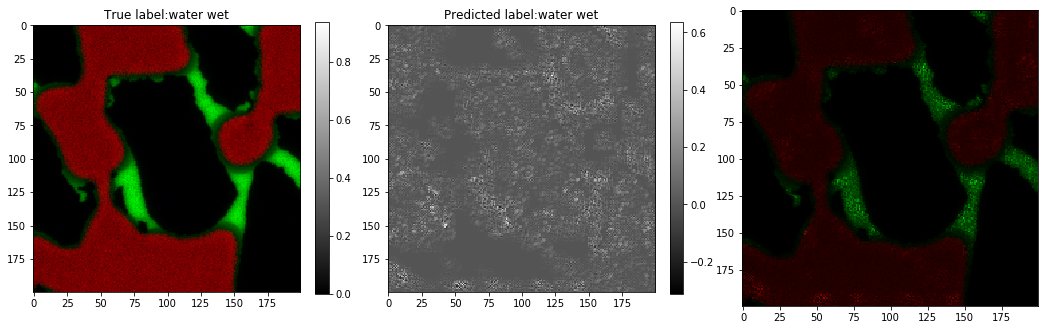

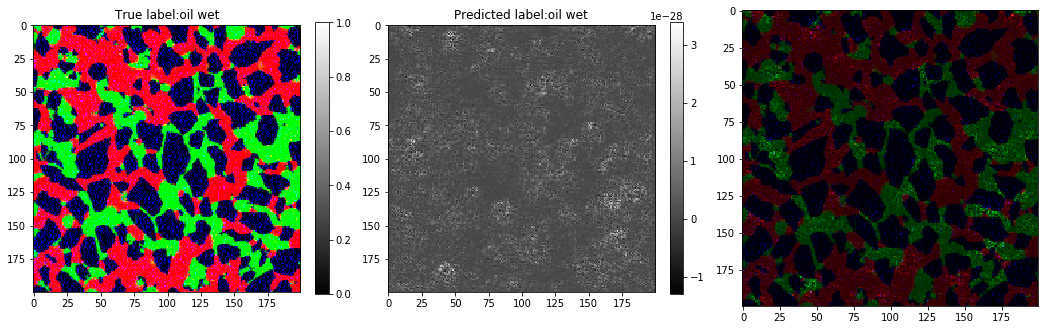

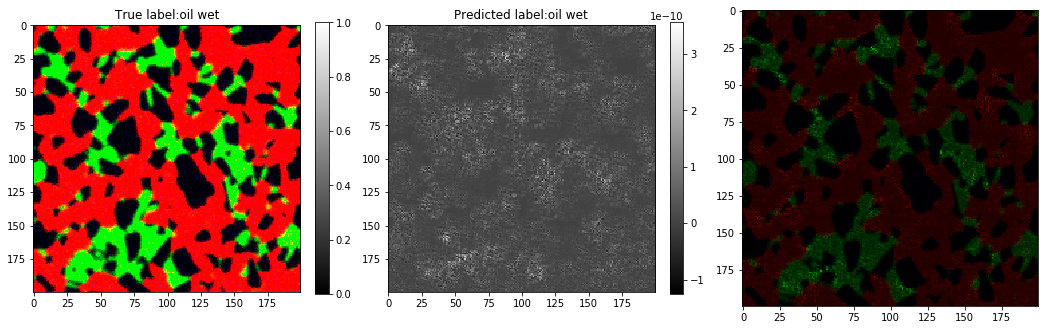

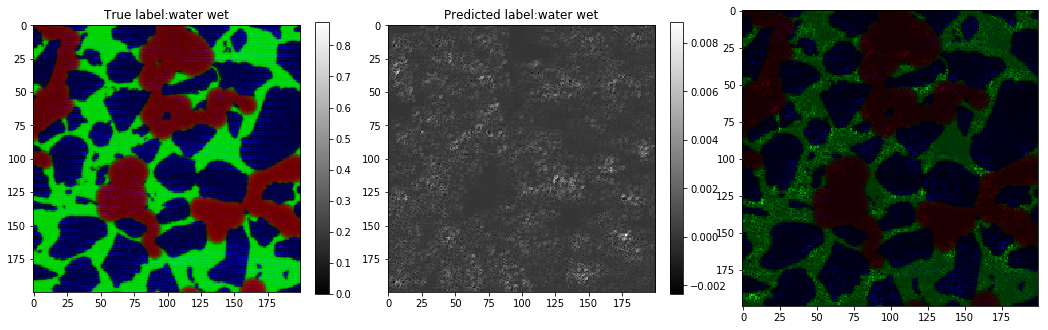

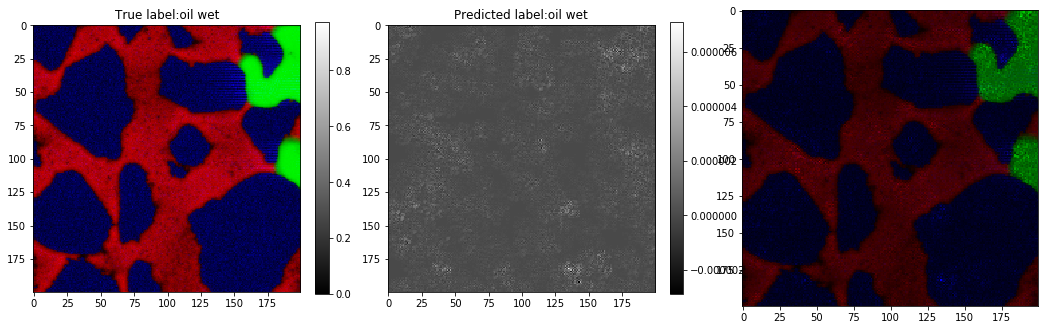

In [113]:
for k in range(5):
    plot_saliency_map(test_data[[k], ...], test_ind_correct_score[k])